## Preprocessing the Dataset

#### Notebook Description
This is a notebook that preprocesses the dataset for the project. It is designed to be run in Google Colab,  but can be run locally. If run locally, the dataset all_hourly_data.h5 should be in a folder /data within the project folder. The output of this notebook is

#### MIMIC-III Dataset
The MIMIC-III dataset is a large dataset of de-identified health data. It is available from the Physionet website: https://physionet.org/content/mimiciii/1.4/. It contains health related data from patients who were admitted to the critical care units of Beth Isreal Deaconess Medical Center from 2001 to 2012. It consists of both static and dynamic data. In addition to patient demographics, there is data acquired from the hospital that is not necessarily related to the patient's intensive care unit (ICU) stay, and the data related to the ICU stay such as vital signs, laboratory tests, diagnostic codes, medications, etc. This includes data from bedside monitoring systems, and the "chart" (electronic health record) data including provider's notes.
Patient Characteristics:
There are data associated with 53,423 distinct adult (age 16 and above) hospital admissions of 38,597 distinct adult patients. There are also data for 7870 neonate admissions, which we will eliminate from our data for analysis.

#### MIMIC-Extract data
MIMIC Extract is an open source pipeline to "extract, preprocess, and represent data from MIMIC-III v1.4.", as described in the paper "MIMIC-Extract: A Data Extraction, Preprocessing, and Representation Pipeline for MIMIC-III." (arXiv:1907.08322). The code is available at: [MIMIC_Extract](https://github.com/MLforHealth/MIMIC_Extract).
The extraction process results in data that includes well-formatted time-series data for clinically-meaningful prediction tasks. The time-varying data are discretized into hourly buckets, standardized, and aggregated into clinically meaningful representations.
The cohort of patients includes all adult patients whose ICU stay is their first, and that stay lasts at least 12 hours, and less that 10 days. This represents a generic cohort, not task-specific, and therefore can be adapted for many different clinical prediction tasks.
The extraction procedure is extensible and you may configure the cohort selection process. Using the default parameters for cohort selection, the data consists of 34,472 patients.About the all_hourly_data.h5 file:  It is a large file that contains all the hourly data for all patients in the MIMIC-III database. The "all_hourly_data.h5" file is the result of the pipeline using the default parameters, and is supplied by the authors of the MIMIC-Extract paper. The file is available for download from Google Cloud (with appropriate credentialing from [Physionet](https://mimic.mit.edu/docs/gettingstarted/)), and a link is provided on the MIMIC_Extract GitHub page.

The h5 datafile format is a hierarchical data format that is optimized for storing large amounts of data. It is a binary format, and is not human-readable. The data is stored in a hierarchical filesytem-like format, with each node in the hierarchy being a group or a dataset. A group is a container that can hold datasets and other groups. A dataset is a multidimensional array of data elements. The data can be read directly into a pandas dataframes, which is what we will do in this notebook.

This data will be processed using the MIMIC-III preprocessing pipeline as described in 

The following three cells are used to mount the Google Drive to the Colab notebook. This is only necessary if running in Colab. Skip to the next cell if running locally.

In [3]:
# Where are we?
%ls

sample_data/


### Mount Google Drive
I am setting this project up to run in Google Colab, and I am using Google Drive to store the project code and data. The following cell mounts the Google Drive to the Colab notebook.

In [4]:
# Mount our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Change to the project directory - yours may be different
%cd /content/drive/MyDrive/dl4h_project/DynST/
%ls

/content/drive/MyDrive/dl4h_project/DynST
causal.ipynb            outputs/                          pyproject.toml
config.yaml             poetry.lock                       README.md
coxph_model.ipynb       project_causal.ipynb              results20230416.txt
data/                   project_coxph_model.ipynb         run.py
dl4hProjectSetup.ipynb  project_model.ipynb               src/
multirun/               project_preprocess_dataset.ipynb


In [6]:
import logging

from pathlib import Path
import numpy as np
import pandas as pd
from scipy.special import expit, logit

In [ ]:
log = logging.getLogger(__name__)

### Mimic3Pipeline Class
This class contains functions which prepare the data for analysis. The source of the data is the h5 file that is the output of the MIMIC-Extract pipeline. The data is read into a pandas dataframes, and processed to prepare it for analysis. The processing steps include:
- filtering out stays that are less than 16 hours or greater than 128
- replace age values > 90 with 90
- standardize the continuous variables
- create the synthetic hazard function according to the formula in the paper:
  $$h(t) = H_o exp(-\lambda t) * exp(\theta A) * exp(\sum_{j=1}^{4}\beta_j Z_j)* exp(log(1.02)tZ_*) * exp(\sum_{j=1}^{4}\gamma_j g(V_j^{(t)}))$$
  where



In [ ]:
class Mimic3Pipeline():
    def __init__(
        self, work_dir, length_range=(16,128), min_code_count=100, n_vitals=25, seed=28
        ):
        self.work_dir = work_dir # passed in as parameter 
        self.input = pd.HDFStore(work_dir + "/data/all_hourly_data.h5")
        Path(f"{work_dir}/data/preprocessed_{seed}").mkdir(parents=True, exist_ok=True)
        self.outpath = f"data/preprocessed_{seed}"
        # minimum and maximum length of stay in hours
        self.min_length = length_range[0] # 16
        self.max_length = length_range[1] # 128
        self.min_code_counts = min_code_count # 100
        self.n_vitals = n_vitals # 25
        self.stay_lengths = None
        # create a dictionary to store arrays of data
        self.arrays = {}
        # baseline hazard
        self.H0 = 0.001
        # rate of hazard decay
        self.labda = 0.25
        self.seed = seed # 28
        np.random.seed(seed)
        # static coefficients 
        # from samples of a uniform distribution (every value equally likely to occur)
        self.beta = np.random.uniform(0.7, 1.2, size=4)
        # dynamic coefficients
        self.gamma = np.random.uniform(0.1, 0.3, size=4)
        # treatment effect on hazards
        self.alpha = -0.5

    def run(self):
        log.info("Beginning pipeline")
        # build index of patients
        # create a pandas df of interventions from the input hdf5 file
        interventions = self.input["interventions"].reset_index()
        # for each patient in the interventions df, 
        # determine the length of their stay in hours (each column is a different hour)
        stay_lengths = interventions.groupby("subject_id").size()
        # filter out patients with stays that are too short (<16 hrs) or too long (>128 hrs)
        self.stay_lengths = stay_lengths[
            (stay_lengths >= self.min_length) & (stay_lengths <= self.max_length)
            ]
        self.stay_lengths.name="stay_length"
        self.arrays["patient_index"] = self.stay_lengths.index.to_numpy()
        self.process_patients_data()
        self.process_codes()
        self.process_vitals()
        self.arrays["hourly_index"] = self.vitals.index.get_level_values(0)
        # generate labels using the function below
        self.features = self.semisynth_features()
        # fixed interventions
        self.features["treated"] = 1
        self.features["control"] = 0
        df_sim = self.simulate_treatment(self.features.copy())
        self.extract_treatment(df_sim)
        df_sim =  self.simulate_outcomes(df_sim)
        self.arrays["survival"] = df_sim["corrected_survival"].to_numpy()
        self.arrays["hazards"] = df_sim["hazard"].to_numpy()
        self.summary_statistics(df_sim)

        log.info("Writing data")
        for key, arr in self.arrays.items():
            fname = f"{self.work_dir}/{self.outpath}/{key}.npy"
            np.save(fname, arr)
        df_sim.to_csv(f"{self.work_dir}/{self.outpath}/df_sim{self.seed}.csv")
        df_sim.to_csv(self.work_dir + f"/data/mimic3_df_{self.seed}.csv")
        log.info("Pipeline completed")

        
    def extract_treatment(self, simulated):
        # groupby col "subject_id" check if values in column "A" are True.
        # casts the resulting True/False into 1 (True) and 0 (False) using the astype() method.
        treatment = simulated.groupby("subject_id")["A"].any().astype(int)
        # This line adds the array "treatment" to the "arrays" dictionary with key "treatment".
        # to_numpy() method to obtain the Numpy array from the pandas Series object.
        self.arrays["treatment"] = treatment.to_numpy()


    def process_patients_data(self):
        # create a pandas df of patients from the input hdf5 file
        demog = self.input["patients"]
        # select gender and age columns
        demog = demog[["gender", "age"]]
        d = {"F":0, "M":1}
        # set gender to 0 or 1
        demog["gender"] = demog["gender"].apply(lambda x: d.get(x)).astype(int)
        # replace values greater than 90 with 90
        demog["age"] = demog["age"].clip(upper=90)
        # standardize age with mean 0 and std 1 using z-score
        demog["age"] = (demog["age"] - demog["age"].mean()) / demog["age"].std()
        # set the index of the df (with gender and age columns) to the subject_id
        demog = demog.reset_index().set_index("subject_id")[["gender", "age"]]
        # join the stay_lengths df with the demog df
        self.demog = demog.join(self.stay_lengths, how="right")
        self.arrays["demog"] = self.demog[["gender", "age"]].to_numpy()


    def process_codes(self):
        log.info("Processing codes")
        # create a pandas df of codes (subject_id, icd9_codes) reset the index
        codes = self.input["codes"].reset_index()[["subject_id", "icd9_codes"]].drop_duplicates(["subject_id"])
        # join the stay_lengths df with the codes df
        codes = codes.set_index("subject_id").join(self.stay_lengths, how="right")
        # explode will create a new row for each code if there is a list of codes in a row
        codes = codes.explode("icd9_codes")
        code_counts = codes["icd9_codes"].value_counts()
        # filter out codes that occur less than 100 times
        code_counts = code_counts[code_counts >= self.min_code_counts]
        code_counts.name = "count"
        code_counts = code_counts.to_frame()
        # merge the code_counts df with the codes df
        codes = codes.merge(code_counts, left_on="icd9_codes", right_index=True, how="left")
        codes["icd9_codes"] = codes["icd9_codes"].mask(codes["count"].isna())
        codes["icd9_codes"] = codes["icd9_codes"].fillna("unk")
        self.codes = codes
        self.arrays["code_index"] = codes.index.to_numpy()

        # np.unique() returns the unique values in the array and the indices of the unique values
        # "code_lookup" is a list of unique codes, "codes" are the indices of the codes in "code_lookup"
        self.arrays["code_lookup"], self.arrays["codes"] = np.unique(
            codes["icd9_codes"], return_inverse=True
            )
    

    def process_vitals(self):
        log.info("Processing vitals")
        # create a pandas df of vitals, dropping the hadm_id and icustay_id columns
        vitals = self.input["vitals_labs_mean"].droplevel(['hadm_id', 'icustay_id'])
        # reset the index
        vitals.columns = vitals.columns.get_level_values(0)
        # create a list of the top n_vitals (25) most common vitals
        vitals_list = vitals.notna().sum(0).sort_values(ascending=False).head(self.n_vitals).index
        vitals = vitals[vitals_list]
        # fill missing values with the previous value
        vitals = vitals.fillna(method="ffill")
        vitals = vitals.fillna(method="bfill")
        mean = np.mean(vitals, axis=0)
        std = np.std(vitals, axis=0)
        # standardize vitals with mean 0 and std 1 using z-score
        vitals = (vitals - mean) / std
        self.vitals = vitals.join(self.stay_lengths, how="right").drop(columns = "stay_length")
        self.arrays["vitals"] = self.vitals.to_numpy()

    def simulate_outcomes(self, df, treatment_col="A"):
        t = df.index.get_level_values(1)
        ###### Synthetic Hazard Function ######

        ## baseline hazard ##
        # The Lindy effect
        # baseline hazard = 0.001 * exp(- 0.25 * t) # using default values, t in hours
        df["baseline_hazard"] = self.H0 * np.exp(- self.labda * t)
        
        ## apply treatment effect ##
        # column can be "A", "control" (all zero), or "treat" (all one)
        df["hazard"] = df["baseline_hazard"] * np.exp(self.alpha * df[treatment_col])

        ## apply static variables ##
        # beta is from a uniform(0.7, 1.2) distribution
        X = df[["gender", "hypertension", "coronary_ath", "atrial_fib"]]
        df["hazard"] *= np.exp((X * self.beta).sum(1))

        ## apply temporal interaction ##
        # "criticl" (Z) is an indicator for severely ill patients, those with 2 or more 
        # of the following conditions: hypertension, coronary artery disease, atrial fibrillation
        # if the patient is severely ill, the hazard increases by 2% per hour,
        # thus violating the proportional hazards assumption
        df["critical"] = (df[["hypertension", "coronary_ath", "atrial_fib"]].sum(1) > 1).astype(int)
        df["hazard"] *= np.exp(np.log(1.02) * t * df["critical"])

        ## time-varying variables ##
        V = df[["hematocrit", "hemoglobin", "platelets", "mean blood pressure"]]
        # note, pandas.where:
        # if V is < 0, keep the original value, otherwise set to 0, then square the result
        V = V.where(V < 0, 0)**2
        V = V.clip(upper=3)
        df["hazard"] *= np.exp((V * self.gamma).sum(1))
        
        # stabilize hazards and convert to survival probs
        df["hazard"] = df["hazard"].clip(lower = 1e-8, upper=0.1)
        df["q"] = 1 - df["hazard"]
        df["survival_prob"] = df.groupby("subject_id")["q"].cumprod()
        np.random.seed(self.seed)
        # add jittering
        eps = np.random.normal(loc=0, scale=0.5, size=df["survival_prob"].shape)
        df["survival_prob"] = expit(logit(df["survival_prob"]) + eps)
        df["survives"] = np.random.binomial(1, df["survival_prob"])
        return self.corrected_survival_labels(df)


    def simulate_treatment(self, df):
        # generate propensity scores
        df_flat = df.groupby(level=0).head(1)
        df_flat["critical"] = (
                df_flat[["hypertension", "coronary_ath", "atrial_fib"]].sum(1) > 1
            ).astype(int).to_numpy()
        df_flat["propensity"] = df_flat["critical"] * 0.8 + (1 - df_flat["critical"]) * 0.2
        np.random.seed(self.seed)
        # randomly assign treatment
        df_flat["A"] = np.random.binomial(1, df_flat["propensity"])
        df = df.join(df_flat["A"], how="left")
        df["A"].fillna(method="ffill", inplace=True)
        return df



    def semisynth_features(self):
        df = self.demog[["gender", "stay_length"]]
        # standardize stay length
        df["stay_length"] = (df["stay_length"] - df["stay_length"].mean()) / df["stay_length"].std()
        conf_codes = self.codes.copy()
        conf_codes["hypertension"] = (conf_codes["icd9_codes"] == "4019")
        conf_codes["coronary_ath"] = (conf_codes["icd9_codes"] == "41401")
        conf_codes["atrial_fib"] = (conf_codes["icd9_codes"] == "42731")
        conf_codes = conf_codes.groupby(conf_codes.index)[["hypertension", "coronary_ath", "atrial_fib"]].any().astype(int)
        conf_vitals = self.vitals[["hematocrit", "hemoglobin", "platelets", "mean blood pressure"]]
        return df.join(conf_codes).join(conf_vitals)

    @staticmethod
    def corrected_survival_labels(df):
        # identify timestep at which first failure occurs (if applicable)
        first_failure = df.reset_index(level="hours_in")
        first_failure = first_failure[first_failure["survives"] == 0].groupby(level=0).first()
        first_failure = first_failure.set_index("hours_in", append=True)
        first_failure["first_failure"] = True
        first_failure = first_failure["first_failure"]
        # label censored patients
        censored = df.reset_index(level="hours_in")
        censored = (censored["survives"] == 1).groupby(level=0).all()
        censored.name = "censored"
        # combine
        df_sim = df.join(first_failure, how="left")
        df_sim = df_sim.reset_index(level="hours_in").join(censored, how="left").\
            set_index("hours_in", append=True)
        # get corrected survival labels: 1 until first failure, then zero
        df_sim["corrected_survival"] = df_sim["first_failure"]
        df_sim["corrected_survival"] = df_sim.groupby(level=0)["corrected_survival"].bfill()
        df_sim["corrected_survival"] = df_sim["corrected_survival"].fillna(False)
        df_sim["corrected_survival"] = (df_sim["corrected_survival"] | df_sim["censored"]).astype(int)
        df_sim["corrected_survival"] = df_sim["corrected_survival"].mask(df_sim["first_failure"].fillna(False), 0)
        return df_sim

    def summary_statistics(self, df_sim):
        n = df_sim.reset_index()["subject_id"].nunique()
        c = df_sim[df_sim["first_failure"] == True].shape[0]
        tau = 16
        log.info(f"{n:,} total patients")
        log.info(f"{n - c:,} censored ({100*(n - c)/n:.2f} %)")
        lifetimes = df_sim.groupby(level=0)["corrected_survival"].sum().to_numpy()
        treated_ix = df_sim.groupby(level=0)["A"].any()
        log.info(f"Mean time to censoring or failure: {np.mean(lifetimes):.2f} hours")
        rst = self.rmst(df_sim, tau)
        log.info(f"Mean restricted survival time: {np.mean(rst):.2f} hours, tau = {tau}")
        unadj_ate = rst[treated_ix].mean() - rst[~treated_ix].mean()
        log.info(f"Observed treatment effect: {unadj_ate:.2f} hours")
        # calculate true ATE
        df_treated = self.simulate_outcomes(self.features, "treated")
        rmst_treated = np.mean(self.rmst(df_treated, tau))
        df_control = self.simulate_outcomes(self.features, "control")
        rmst_control = np.mean(self.rmst(df_control, tau))
        log.info(f"True treatment effect: {rmst_treated - rmst_control:.2f} hours")

    @staticmethod
    def rmst(df, tau):
        restr = df.groupby(level=0)["corrected_survival"].head(tau)
        rst = restr.groupby(level=0).sum()
        return rst.to_numpy()


### Below is from dataset.py

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

In [ ]:
class Mimic3Dataset(Dataset):
    def __init__(self, work_dir, seed, intervention=None):
        fdir = f"{work_dir}/data/preprocessed_{seed}"
        self.f = {}
        for fname in os.listdir(fdir):
            if fname.endswith(".npy"):
                self.f[fname[:-4]] = np.load(
                    f"{fdir}/{fname}", allow_pickle=True
                    )
        self.ix = self.f["patient_index"]
        self.code_lookup = np.insert(self.f["code_lookup"], 0, "pad")
        self.codes = self.f["codes"] + 1
        self.n_codes = len(self.code_lookup)
        self.n_vitals = self.f["vitals"].shape[1]
        self.n_demog = self.f["demog"].shape[1]
        self.pad_value = - 100
        # if supplied, represents treatment (True) or control (False)
        self.intervention = intervention



    def __len__(self):
        return len(self.f["treatment"])

    def __getitem__(self, index):
        item = {}
        j = self.ix[index]
        if self.intervention is None:
            item["treatment"] = self.f["treatment"][index]
        else:
            item["treatment"] = int(self.intervention)
        item["demog"] = self.f["demog"][index]
        item["codes"] = torch.tensor(
            self.pad_bincount(self.f["codes"][self.f["code_index"] == j])
        )
        item["vitals"] = torch.tensor(
            self.f["vitals"][self.f["hourly_index"] == j]
        ).float()
        item["survival"] = torch.tensor(
            self.f["survival"][self.f["hourly_index"] == j]
        )
        return item

    def pad_bincount(self, records):
        # get counts of each cod
        records = np.bincount(records)
        # pad each vector to length T, all possible codes
        padded = np.zeros(self.n_codes)
        padded[: len(records)] = records
        return torch.from_numpy(padded).float()

In [ ]:
def padded_collate(batch, pad_index, causal=False):
    res = {}
    treatment = torch.tensor(np.array([d["treatment"] for d in batch]))
    demog = torch.tensor(np.array([d["demog"] for d in batch])).float()
    if causal:
        res["treatment"] = torch.tensor(np.array([d["treatment"] for d in batch]))
        res["static"] = torch.tensor(np.array([d["demog"] for d in batch])).float()
    else:
        res["static"] = torch.cat([demog, treatment.unsqueeze(1)], 1)
    res["codes"] = torch.stack([d["codes"] for d in batch])
    res["vitals"] = pad_sequence(
        [d["vitals"] for d in batch], batch_first=True, padding_value=pad_index
    )
    res["survival"] = pad_sequence(
        [d["survival"] for d in batch], batch_first=True, padding_value=pad_index
    )
    return res

In [ ]:
# Import the os module
import os

# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: /content/drive/MyDrive/dl4h_project/DynST


In [ ]:
%pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 24.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# set the default parameters from the config.yaml file
# preprocess
preprocess_seed = 30

# train
train_frac = .7
val_frac = .15
accelerator = "gpu"
devices = 1
max_epochs = 5
batch_size = 32
train_seed = 0

causal = False

# model
_target_ = "src.model.DST"
d_model = 32
n_blocks = 3
n_heads = 8
dropout = .1
pad = -100
dynamic = True
lr = 0.001
alpha = 0.01

pipeline = Mimic3Pipeline(work_dir=cwd, seed=preprocess_seed)
pipeline.run()
dataset = Mimic3Dataset(work_dir=cwd, seed=preprocess_seed)

train_size = int(train_frac * len(dataset))
if train_frac + val_frac == 1.0:
    val_size = len(dataset) - train_size
    test_size = 0
else:
    val_size = int(val_frac * len(dataset))
    test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(
    dataset,
    (train_size, val_size, test_size),
    torch.Generator().manual_seed(train_seed)
)

   subject_id  hadm_id  icustay_id  hours_in  vent  vaso  adenosine  \
0           3   145834      211552         0     1     0          0   
1           3   145834      211552         1     1     1          0   
2           3   145834      211552         2     1     1          0   
3           3   145834      211552         3     1     1          0   
4           3   145834      211552         4     1     1          0   

   dobutamine  dopamine  epinephrine  isuprel  milrinone  norepinephrine  \
0           0         0            0        0          0               0   
1           0         1            0        0          0               0   
2           0         1            0        0          0               0   
3           0         0            0        0          0               0   
4           0         0            0        0          0               1   

   phenylephrine  vasopressin  colloid_bolus  crystalloid_bolus  nivdurations  
0              0            0       

<ipython-input-22-5f74a953ebd2>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stay_length"] = (df["stay_length"] - df["stay_length"].mean()) / df["stay_length"].std()
<ipython-input-22-5f74a953ebd2>:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flat["critical"] = (
<ipython-input-22-5f74a953ebd2>:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

## Additional Data Exploration - not necessary for the preprocessing

#### Below is a plot of the baseline hazard function which includes the decreasing risk the longer they survive (the Lindy effect)

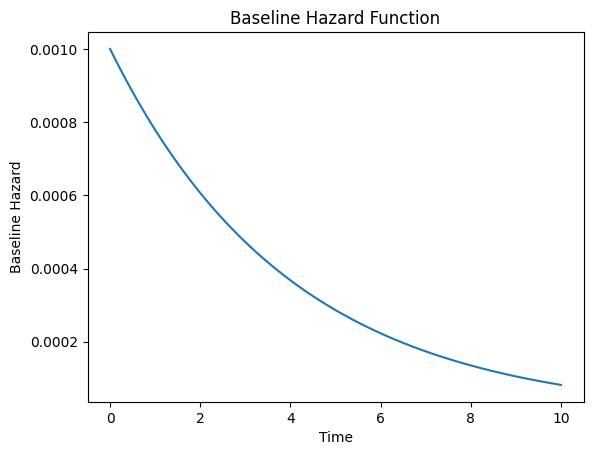

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Define the function
def baseline_hazard(t):
    return 0.001 * np.exp(-0.25 * t)

# Define the time array
t = np.linspace(0, 10, 100)

# Calculate the baseline hazard values
baseline_hazard_values = baseline_hazard(t)

# Create the plot
plt.plot(t, baseline_hazard_values)
plt.xlabel('Time')
plt.ylabel('Baseline Hazard')
plt.title('Baseline Hazard Function')
plt.show()
